**Loading and Preprocessing Image Datasets with PyTorch**

Link to Dataset: https://www.kaggle.com/datasets/nafishamoin/new-bangladeshi-crop-disease

1. Install Libraries

In [1]:
# !pip install torch
# !pip install torchvision
# !pip install numpy
# !pip install matplotlib

2. Importing libraries

In [2]:
# !pip install torchvision

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

3. **Loading the Dataset**

   We will use the torchvision.datasets.ImageFolder to load the dataset.
   
   **Generate a Kaggle API Key**
   Go to your Kaggle account settings: https://www.kaggle.com/account/account

   Scroll down to the "API" section.

   Click on "Create New API Token".

   This will download a file named kaggle.json containing your API key.
   Upload the Kaggle API Key to Google Colab                                                
   In your Google Colab notebook, create a new cell and run the following code
   to upload the kaggle.json file:                                                                        Click on "Choose Files" and select the kaggle.json file from your local machine.        


In [4]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from google.colab import files
files.upload()

Saving kaggle2.json to kaggle2.json


{'kaggle2.json': b'{"username":"duncanngacha","key":"35484c009335c3e1468b92ca02e83629"}'}

       Move the API Key to the Correct Directory
       Run the following commands in a new cell to create the .kaggle directory and move the kaggle.json file to it:
       

In [6]:
!mkdir -p ~/.kaggle
!mv kaggle2.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle2.json

      Download the Dataset
      

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nafishamoin/new-bangladeshi-crop-disease")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/new-bangladeshi-crop-disease


In [8]:
!mkdir -p ./SDS-CP028
!mv /root/.cache/kagglehub/datasets/nafishamoin/new-bangladeshi-crop-disease/versions/2 ./SDS-CP028/

mv: cannot stat '/root/.cache/kagglehub/datasets/nafishamoin/new-bangladeshi-crop-disease/versions/2': No such file or directory


In [9]:
import os
import shutil
import random

# Set random seed for reproducibility
random.seed(42)

# Paths
original_dataset_dir = './SDS-CP028/2/BangladeshiCrops/BangladeshiCrops/Crop___Disease'  # Root path where Corn, Potato, etc. folders are
base_dir = 'SmartLeaf_dataset'                            # Where you want to create train/val/test folders
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Split ratios
train_ratio = 0.8
val_ratio = 0.1
# test_ratio = 0.1 (implicitly the remaining)

# Create train, val, and test directories
for split_dir in [train_dir, val_dir, test_dir]:
    os.makedirs(split_dir, exist_ok=True)

# Traverse two levels: crop -> class
for crop_folder in os.listdir(original_dataset_dir):
    crop_path = os.path.join(original_dataset_dir, crop_folder)

    if os.path.isdir(crop_path):
        # Now go inside each disease class
        for class_folder in os.listdir(crop_path):
            class_path = os.path.join(crop_path, class_folder)

            if os.path.isdir(class_path):
                images = os.listdir(class_path)
                random.shuffle(images)

                total_images = len(images)
                train_split = int(total_images * train_ratio)
                val_split = int(total_images * (train_ratio + val_ratio))

                train_images = images[:train_split]
                val_images = images[train_split:val_split]
                test_images = images[val_split:]

                # Create corresponding class folders under train/val/test
                train_class_dir = os.path.join(train_dir, class_folder)
                val_class_dir = os.path.join(val_dir, class_folder)
                test_class_dir = os.path.join(test_dir, class_folder)

                os.makedirs(train_class_dir, exist_ok=True)
                os.makedirs(val_class_dir, exist_ok=True)
                os.makedirs(test_class_dir, exist_ok=True)

                # Copy images
                for img in train_images:
                    shutil.copy2(os.path.join(class_path, img), os.path.join(train_class_dir, img))

                for img in val_images:
                    shutil.copy2(os.path.join(class_path, img), os.path.join(val_class_dir, img))

                for img in test_images:
                    shutil.copy2(os.path.join(class_path, img), os.path.join(test_class_dir, img))

print("Dataset split into train/val/test successfully!")


Dataset split into train/val/test successfully!


4. Preprocessing the Dataset

   Preprocessing is an essential step in preparing the data for training. Common preprocessing steps include resizing, normalization, and data augmentation.

  Define the transformations:

In [10]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


batch_size = 4

5.  Creating Data Loaders
  Data loaders in PyTorch help in efficiently loading data during training.
  We will create a data loader for our training dataset.

In [11]:
# Create datasets
train_dataset = torchvision.datasets.ImageFolder(root='SmartLeaf_dataset/train', transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root='SmartLeaf_dataset/test', transform=transform)
eval_dataset = torchvision.datasets.ImageFolder(root='SmartLeaf_dataset/val', transform=transform)

In [12]:
# Create loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

In [13]:
# %%
CLASSES = ['Corn___Common_Rust', 'Corn___Gray_Leaf_Spot', 'Corn___Healthy','Corn___Northern_Leaf_Blight',
           'Potato___Early_Blight','Potato___Healthy','Potato___Late_Blight','Rice___Brown_Spot','Rice___Healthy',
           'Rice___Leaf_Blast','Rice___Neck_Blast','Wheat___Brown_Rust','Wheat___Healthy','Wheat___Yellow_Rust',
        ]
NUM_CLASSES = len(CLASSES)

6. Define ImageMultiClassificationClass

In [14]:
class ImageMulticlassClassificationNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)  #out BS , 16, 30,30
        self.Maxpool1 = nn.MaxPool2d(2, 2)   #out BS , 16, 15,15
        self.conv2 = nn.Conv2d(32, 64, 3) #out BS , 32, 13,13
        self.MaxPool2 = nn.MaxPool2d(2,2) #out BS , 32, 6,6
        self.fc1 = nn.Linear(64*6*6, 128) # out: (BS, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, NUM_CLASSES)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x) # out: (BS, 16, 30, 30)
        x = self.relu(x)
        x = self.Maxpool1(x) # out: (BS, 16, 15, 15)
        x = self.conv2(x) # out: (BS, 32, 13, 13)
        x = self.relu(x)
        x = self.MaxPool2(x) # out: (BS, 32, 6, 6)
        x = x = torch.flatten(x, 1)   #Out after  BS, 32*6*6
        x = self.fc1(x)     # BS ,128
        x = self.relu(x)
        x = self.fc2(x)     # BS, 64
        x = self.relu(x)
        x = self.fc3(x)     #BS , NUM_CLASSES
        #x = self.softmax(x)
        return x

7. Train the Model

In [15]:
#input = torch.rand(1, 1, 32, 32) # BS, C, H, W
model = ImageMulticlassClassificationNet()
#print(model(input).shape)

# %%
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
# %% training
NUM_EPOCHS = 20
for epoch in range(NUM_EPOCHS):
    for i, data in enumerate(train_loader, 0):
       inputs, labels = data
       optimizer.zero_grad()
       outputs = model(inputs)


       loss = loss_fn(outputs, labels)
       loss.backward()
       optimizer.step()

    print(f'Epoch {epoch}/{NUM_EPOCHS}, Loss: {loss.item():.4f}')

Epoch 0/20, Loss: 0.6445
Epoch 1/20, Loss: 0.4866
Epoch 2/20, Loss: 1.0025
Epoch 3/20, Loss: 0.2409
Epoch 4/20, Loss: 1.1135
Epoch 5/20, Loss: 0.1761
Epoch 6/20, Loss: 0.1861
Epoch 7/20, Loss: 0.3326
Epoch 8/20, Loss: 0.8386
Epoch 9/20, Loss: 0.5836
Epoch 10/20, Loss: 0.5322
Epoch 11/20, Loss: 0.8972
Epoch 12/20, Loss: 0.5484
Epoch 13/20, Loss: 0.0497
Epoch 14/20, Loss: 0.0322
Epoch 15/20, Loss: 1.3083
Epoch 16/20, Loss: 0.0116
Epoch 17/20, Loss: 0.0588
Epoch 18/20, Loss: 0.2596
Epoch 19/20, Loss: 0.4535


8. Evaluate the Model

In [16]:
# %% evaluation mode
model.eval()  # set model to evaluation mode

# Disable gradient calculation (saves memory and computations)
with torch.no_grad():
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    for data in eval_loader:
        inputs, labels = data
        outputs = model(inputs)

        # Get predictions
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

    eval_accuracy = 100 * correct / total
    print(f"Validation Accuracy: {eval_accuracy:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:\n", cm)

Validation Accuracy: 79.17%
Confusion Matrix:
 [[117   0   1   0   0   0   0   0   0   0   0   1   0   0]
 [  2  31   4   8   0   0   3   0   0   0   1   0   0   2]
 [  0   4  99   8   0   0   1   0   0   1   0   2   0   1]
 [  0  15   0  81   0   0   1   0   0   0   0   1   0   0]
 [  0   0   0   0  89   1   8   0   0   0   0   1   0   1]
 [  0   0   0   0   0   6   9   0   0   0   0   0   0   0]
 [  0   0   0   0   2   8  90   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  19  25  16   1   0   0   0]
 [  0   0   0   0   0   0   0   3 137   6   3   0   0   0]
 [  0   0   0   0   0   0   0   3  55  36   4   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  99   0   0   1]
 [  0   2  12   1   0   0   2   0   0   0   1  66   2   4]
 [  0   0   1   0   0   0   0   0   0   0   0   3  98  10]
 [  0   2   0   0   0   0   0   0   0   0   0  10  18  62]]


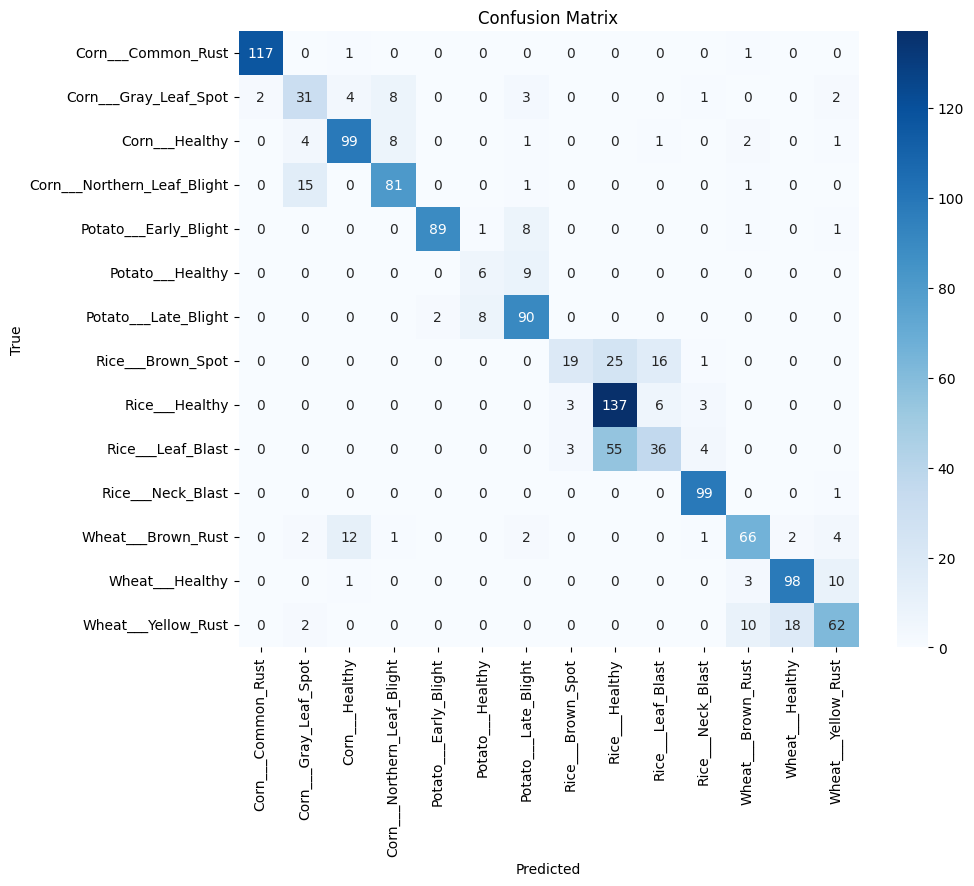

In [17]:
import seaborn as sns

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage:
plot_confusion_matrix(cm, CLASSES)

9. Test the Model

In [18]:
# %% test set evaluation
model.eval()  # just in case

with torch.no_grad():
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)

        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:\n", cm)

Test Accuracy: 75.86%
Confusion Matrix:
 [[119   0   1   0   0   0   0   0   0   0   0   0   0   0]
 [  1  24   2  16   0   0   0   0   0   0   0   2   0   7]
 [  1   0 103   3   0   0   0   0   0   0   0   8   1   1]
 [  0  19   5  69   0   0   1   0   0   0   0   5   0   0]
 [  0   0   0   0  86   0  14   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  16   0   0   0   0   0   0   0]
 [  0   0   0   2   2   0  96   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  17  32  12   1   0   0   0]
 [  0   0   0   0   0   0   0   6 128  14   1   0   0   0]
 [  0   0   0   0   0   0   0  13  50  33   2   0   0   0]
 [  0   0   0   0   0   0   0   0   1   4  90   0   5   0]
 [  2   2   6   2   0   0   2   0   0   0   0  60   2  15]
 [  0   0   2   0   0   0   0   0   0   0   0   2  94  14]
 [  0   0   0   0   0   0   0   0   0   0   0   1  18  74]]


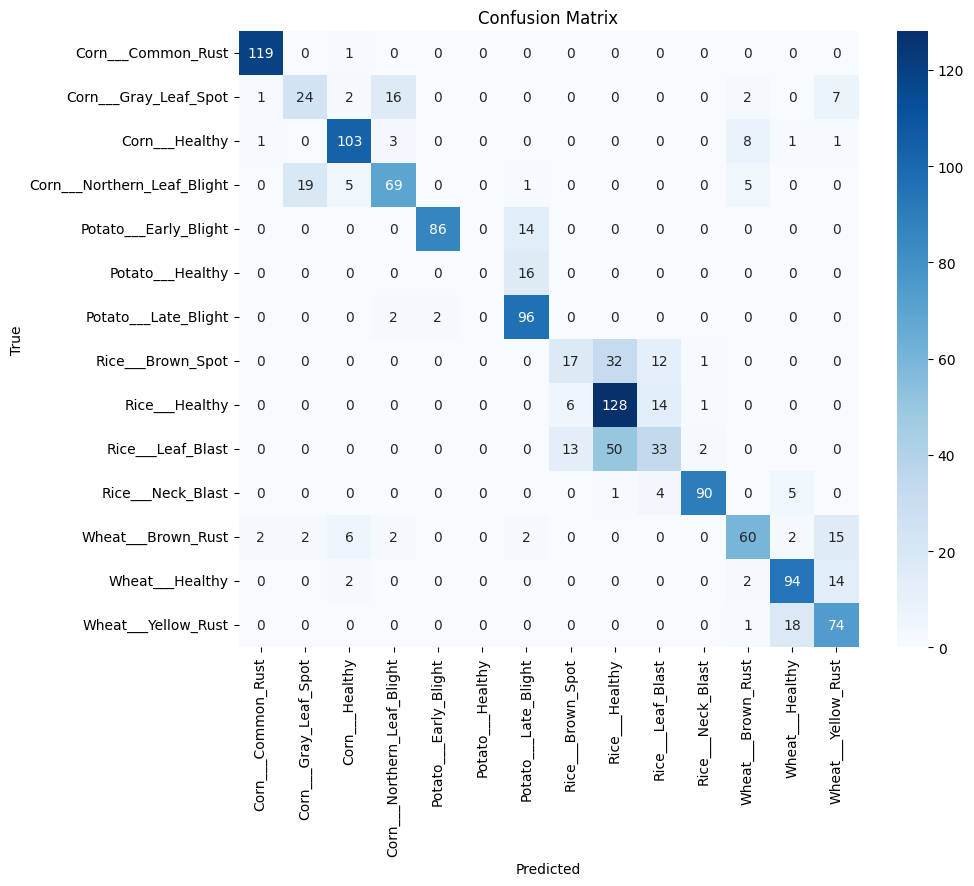

In [19]:
import seaborn as sns

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage:
plot_confusion_matrix(cm, CLASSES)


10. Save Model

In [18]:
#Save Model Weights
# Save model weights (state_dict)
torch.save(model.state_dict(), 'smartleaf_model.pth')
print("Model saved successfully!")


Model saved successfully!


11. Loading the Model Weights

In [19]:
# Initialize the model again
model = ImageMulticlassClassificationNet()

# Load the model weights
model.load_state_dict(torch.load('smartleaf_model.pth'))
model.eval()  # Set the model to evaluation mode
print("Model loaded successfully!")


Model loaded successfully!


12. Performing Inference:

In [49]:
# Sample inference for a new image

# Assume you have a test image that you want to classify
from PIL import Image

# Load your image
image_path = '/content/SDS-CP028/2/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Wheat/Wheat___Yellow_Rust/Yellow_rust1057.jpg'
image = Image.open(image_path)

# Apply the same transformations that you used for training
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


image_tensor = transform(image).unsqueeze(0)  # Add batch dimension: (1, 1, 32, 32)

# Perform inference
with torch.no_grad():
    output = model(image_tensor)  # Forward pass
    _, predicted = torch.max(output, 1)  # Get the class with the highest score

# Print predicted class
predicted_class = CLASSES[predicted.item()]
print(f"Predicted class: {predicted_class}")


Predicted class: Wheat___Yellow_Rust
